In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from datenspende.utils import query_ch_df

In [2]:
neg = pd.read_csv('neg_testdate.csv',index_col=0)
pos = pd.read_csv('pos_testdate.csv',index_col=0)
lc_u = np.load('uid_per_shb_fatigue.npy')

In [3]:
def get_epoch(user_ids):
    
   
    ft = tuple(user_ids)    
    df = query_ch_df(
            #"""DESCRIBE TABLE rocs.test_table"""
        #"""SELECT * FROM rocs.vital_data_epoch WHERE vital_data_epoch.customer IN {formatter}"""
        """SELECT * FROM rocs.vital_data_epoch WHERE vital_data_epoch.customer IN {}""".format(ft) 
        #"""SELECT * FROM rocs.vital_data_epoch LIMIT 5000"""
        )
    return df

In [4]:
lc = get_epoch(lc_u)#['customer']

In [5]:
import datetime

In [6]:
lc.head()

,customer,type,valueType,doubleValue,longValue,booleanValue,timezoneOffset,startTimestamp,endTimestamp,createdAt,source
0,182190,1000,0,1426.0,0.0,0.0,120,1592887959000,1592888728000,1592933432645,2
1,182190,1000,0,2564.0,0.0,0.0,120,1593144804000,1593146187000,1594342194841,2
2,182190,1000,0,6909.0,0.0,0.0,120,1593333071000,1593337065000,1594342194844,2
3,182190,1000,0,1520.0,0.0,0.0,120,1593404338000,1593405158000,1594342194846,2
4,182190,1000,0,2219.0,0.0,0.0,120,1593490972000,1593492150000,1594342194849,2


In [7]:
lc.startTimestamp = lc.startTimestamp//1000
lc.endTimestamp = lc.endTimestamp//1000

In [8]:
lc.startTimestamp = lc.startTimestamp.apply(lambda x: datetime.datetime.fromtimestamp(x))
lc.endTimestamp = lc.endTimestamp.apply(lambda x: datetime.datetime.fromtimestamp(x))

In [9]:
lc['date'] = lc.startTimestamp.apply(lambda x: x.date())

In [10]:
lc = lc.rename(columns={"customer": "user_id"})

In [11]:
lc.head()

,user_id,type,valueType,doubleValue,longValue,booleanValue,timezoneOffset,startTimestamp,endTimestamp,createdAt,source,date
0,182190,1000,0,1426.0,0.0,0.0,120,2020-06-23 04:52:39,2020-06-23 05:05:28,1592933432645,2,2020-06-23
1,182190,1000,0,2564.0,0.0,0.0,120,2020-06-26 04:13:24,2020-06-26 04:36:27,1594342194841,2,2020-06-26
2,182190,1000,0,6909.0,0.0,0.0,120,2020-06-28 08:31:11,2020-06-28 09:37:45,1594342194844,2,2020-06-28
3,182190,1000,0,1520.0,0.0,0.0,120,2020-06-29 04:18:58,2020-06-29 04:32:38,1594342194846,2,2020-06-29
4,182190,1000,0,2219.0,0.0,0.0,120,2020-06-30 04:22:52,2020-06-30 04:42:30,1594342194849,2,2020-06-30


In [12]:
lc = lc.merge(pos[pos['user_id'].isin(lc_u)], how='left', on='user_id')

In [13]:
lc['dt'] = pd.to_datetime(lc['dt'])

In [ ]:
#lc[lc['date'] == lc['dt']]

In [15]:
lc['entries'] = 1

In [16]:
value_types = pd.read_csv('epoch_value_types.csv')

In [17]:
#lc.groupby(['type','user_id']).sum()

In [18]:
value_types = value_types.rename(columns={"id": "type"})

In [19]:
lc = lc.merge(value_types, how='left', on = 'type')

In [20]:
upv = []
vname = []
for v in lc['type'].unique():
    upv.append(len(lc[lc['type'] == v]['user_id'].unique()))
    vname.append(value_types[value_types['type'] == v].code.values[0])

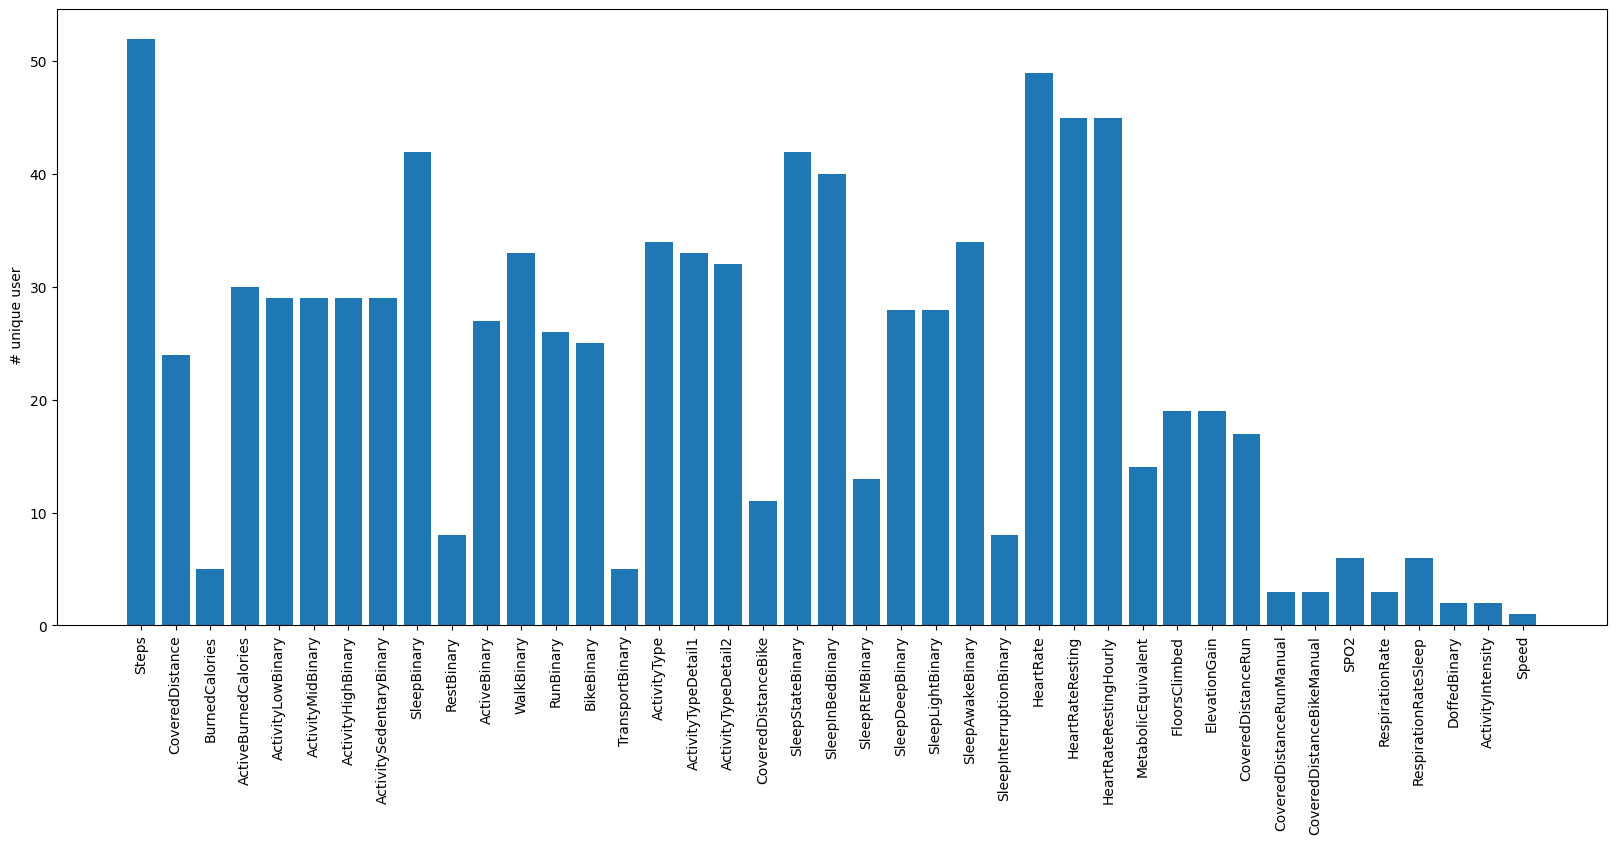

In [21]:
plt.figure(figsize=(20,8))
plt.bar(range(len(lc['type'].unique())), upv)
plt.xticks(range(len(lc['type'].unique())),labels=vname,rotation=90);
plt.ylabel(' # unique user');

## example user

In [30]:
lc['user_id'].unique()

array([182190, 660061,   8703, 559075, 789093, 128235, 278688, 198054,
        23542, 133343, 200221,  83696, 564116, 248652, 968172, 586100,
       138432, 591040, 280091, 288844, 297815, 969827, 146789, 813009,
       290942, 305902, 595740, 357322, 601007, 111479, 325122, 827739,
       118460, 120014, 152430, 361648, 335403, 363804, 388058, 676037,
       443607, 468824, 690345, 494935, 695700, 339053, 524914, 713054,
       630454, 352982, 859881, 865661])

In [32]:
#for u in lc['user_id'].unique():
#    ex = lc[lc['user_id'] == u]
#    if len(ex[(ex['type'] == 2000) & (ex['booleanValue'] == 1)]) != len(ex[(ex['type'] == 2000)]):
#        print(u)
    

In [33]:
ex = lc[lc['user_id'] ==357322]

In [34]:
ex['tdelta'] = ex['endTimestamp'] - ex['startTimestamp']

/tmp/ipykernel_56/136343080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex['tdelta'] = ex['endTimestamp'] - ex['startTimestamp']


In [35]:
ex['tdelta_min'] = ex['tdelta'].apply(lambda x: x.total_seconds()//60)

/tmp/ipykernel_56/2025465141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex['tdelta_min'] = ex['tdelta'].apply(lambda x: x.total_seconds()//60)


In [36]:
#ex[(ex['type'] == 3000) ]['tdelta_min'].value_counts()

In [46]:
ex['tdelta_sec'] = ex['tdelta'].apply(lambda x: x.total_seconds())

/tmp/ipykernel_56/2566538265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex['tdelta_sec'] = ex['tdelta'].apply(lambda x: x.total_seconds())


In [40]:
ex[(ex['startTimestamp'] == ex['startTimestamp'].loc[21897335]) &(ex['endTimestamp'] == ex['endTimestamp'].loc[21897335])]

,user_id,type,valueType,doubleValue,longValue,booleanValue,timezoneOffset,startTimestamp,endTimestamp,createdAt,source,date,dt,entries,code,tdelta,tdelta_min
21897335,357322,3002,1,NaN,68.0,NaN,0,2022-12-12 12:00:00,2022-12-12 13:00:00,1670859188744,3,2022-12-12,2022-04-17,1,HeartRateRestingHourly,0 days 01:00:00,60.0


In [42]:
#plt.scatter(ex[(ex['type'] == 2000) ].iloc[0:10]['startTimestamp'],ex[(ex['type'] == 2000) ].iloc[0:10]['booleanValue'])

Text(0.5, 0, 'steps/sec')

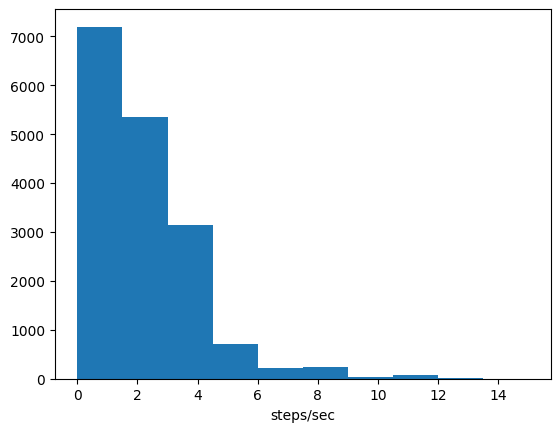

In [58]:
plt.hist(ex[ex['type'] == 1000]['doubleValue']/ex[ex['type'] == 1000]['tdelta_sec'])
plt.xlabel('steps/sec'),

In [49]:
#ty = 1000
#plt.plot(ex[(ex['type'] == ty) ].iloc[0:100]['startTimestamp'],ex[(ex['type'] ==ty) ].iloc[0:100]['doubleValue'])
#plt.ylim(0,100);

In [50]:
#ty = 3001

#plt.scatter(ex[(ex['type'] == ty) ].iloc[100:200]['startTimestamp'],ex[(ex['type'] ==ty) ].iloc[100:200]['longValue'])

/tmp/ipykernel_56/650947517.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.bar(ex[(ex['type'] == 3000) ].groupby('longValue').sum().index, ex[(ex['type'] == 3000) ].groupby('longValue').sum()['tdelta_min'])
/tmp/ipykernel_56/650947517.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  plt.bar(ex[(ex['type'] == 3000) ].groupby('longValue').sum().index, ex[(ex['type'] == 3000) ].groupby('longValue').sum()['tdelta_min'])
/tmp/ipykernel_56/650947517.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Eithe

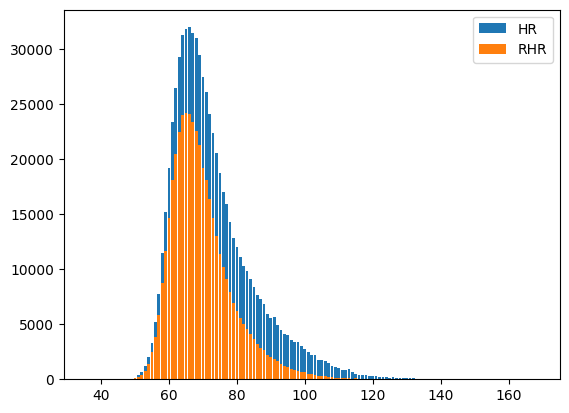

In [51]:
plt.bar(ex[(ex['type'] == 3000) ].groupby('longValue').sum().index, ex[(ex['type'] == 3000) ].groupby('longValue').sum()['tdelta_min'])
plt.bar(ex[(ex['type'] == 3001) ].groupby('longValue').sum().index, ex[(ex['type'] == 3001) ].groupby('longValue').sum()['tdelta_min'])
plt.legend(['HR', 'RHR']);

In [52]:
ex['date'] = pd.to_datetime(ex['date'])

/tmp/ipykernel_56/1619599222.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex['date'] = pd.to_datetime(ex['date'])


In [53]:
td = ex['date'] - ex['dt']  
ex['week_totest'] = td.apply(lambda x: -(x.days// - 7))

/tmp/ipykernel_56/167579026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex['week_totest'] = td.apply(lambda x: -(x.days// - 7))


In [54]:
def phases(week):
    if week < 0:
        ph = 0
    elif (week >= 0 and week <= 3):
        ph = 1
    elif week > 3:
        ph = 2
    return ph

In [55]:
ex['phase'] = ex['week_totest'].apply(lambda x: phases(x))

/tmp/ipykernel_56/1278803933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex['phase'] = ex['week_totest'].apply(lambda x: phases(x))


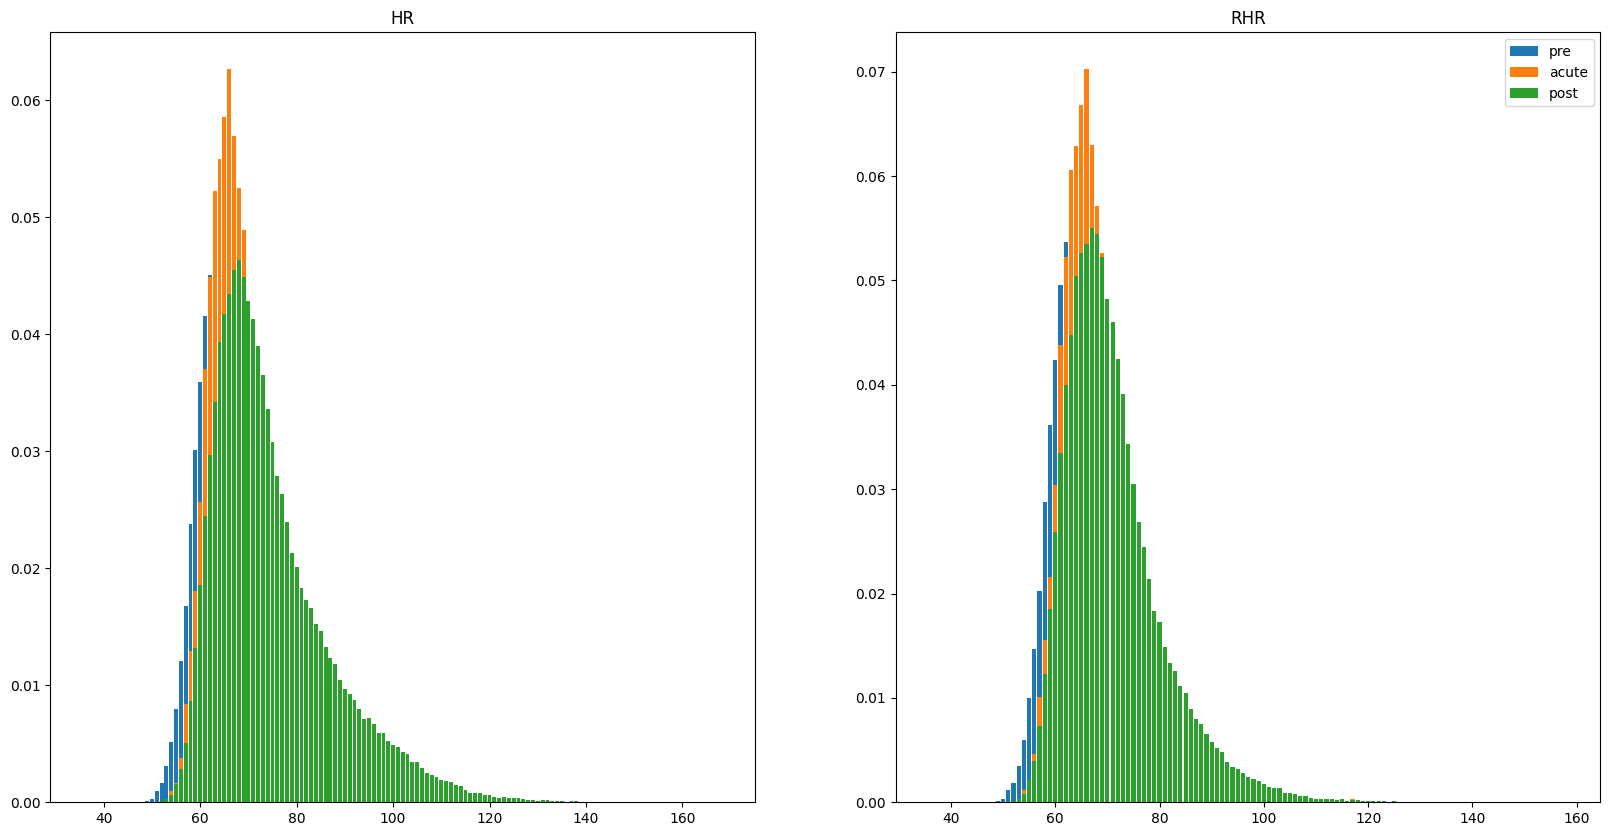

In [56]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
for ph in [0,1,2]:
    hr = ex[(ex['type'] == 3000) & (ex['phase'] == ph) ][['longValue', 'tdelta_min']]    
    rhr = ex[(ex['type'] == 3001) & (ex['phase'] == ph) ][['longValue', 'tdelta_min']]    
    ax[0].bar(hr.groupby('longValue').sum().index, hr.groupby('longValue').sum()['tdelta_min']/hr.groupby('longValue').sum()['tdelta_min'].sum())
    ax[1].bar(rhr.groupby('longValue').sum().index,rhr.groupby('longValue').sum()['tdelta_min']/rhr.groupby('longValue').sum()['tdelta_min'].sum())
    ax[0].set_title('HR')
    ax[1].set_title('RHR')
plt.legend(['pre','acute','post']);